In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
    

In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset, Dataset
import pandas as pd

In [ ]:
ds = load_dataset("toughdata/quora-question-answer-dataset")
# Convert dataset to DataFrame
df = pd.DataFrame(ds['train'])
# Drop duplicates based on the 'question' and 'answer' columns
df_cleaned = df.drop_duplicates(subset=['question', 'answer'])
# Drop rows with null values in specific columns (e.g., 'question' and 'answer')
df_cleaned = df_cleaned.dropna(subset=['question', 'answer'])
# Convert DataFrame back to Dataset
ds_cleaned = Dataset.from_pandas(df_cleaned)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/56402 [00:00<?, ? examples/s]

In [ ]:
#Data Exploration, Cleaning, and Preprocessing:

import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def preprocess_text(text):
  text = text.lower()
  text = re.sub(r'[^\w\s]', '', text)
  tokens = word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  stemmer = PorterStemmer()
  tokens = [stemmer.stem(w) for w in tokens]
  return ' '.join(tokens)

ds = ds.map(lambda example: {'question': preprocess_text(example['question']), 'answer': preprocess_text(example['answer'])})
print(ds)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Parameter 'function'=<function <lambda> at 0x7b26f135d360> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/56402 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 56402
    })
})


Map:   0%|          | 0/56402 [00:00<?, ? examples/s]

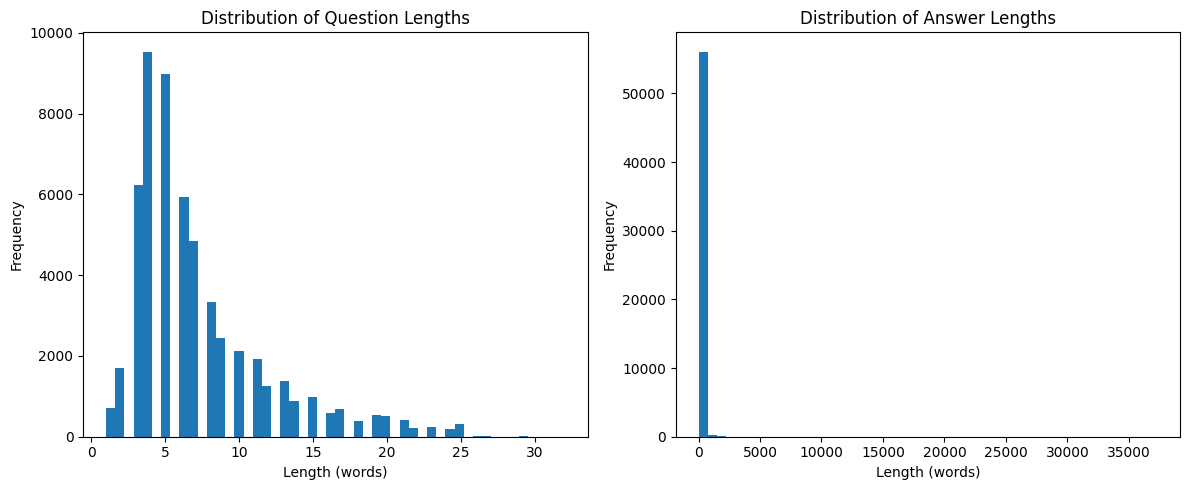

In [10]:
import matplotlib.pyplot as plt

# Calculate lengths of questions and answers
ds = ds.map(lambda example: {'question_length': len(example['question'].split()), 'answer_length': len(example['answer'].split())})

# Create histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(ds['train']['question_length'], bins=50)
plt.title('Distribution of Question Lengths')
plt.xlabel('Length (words)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(ds['train']['answer_length'], bins=50)
plt.title('Distribution of Answer Lengths')
plt.xlabel('Length (words)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=96b2b0aec0b9327585dbe2ef1f9b8c0eca6bc30189764afd4fe4bb21927054df
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import torch
import numpy as np
from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from transformers import default_data_collator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import os

# Device setup (TPU/GPU/CPU)
if 'COLAB_TPU_ADDR' in os.environ:
    print('Using TPU')
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
elif torch.cuda.is_available():
    print('Using GPU')
    device = torch.device("cuda")
else:
    print('Using CPU')
    device = torch.device("cpu")

# Load the dataset with memory mapping
dataset = load_dataset("toughdata/quora-question-answer-dataset")

# Load the tokenizer and model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name).to(device)

# Prepare the dataset
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    answers = examples["answer"]

    # Tokenize questions and answers
    tokenized = tokenizer(
        questions,
        answers,
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Find the start and end token positions for the answer
    start_positions = []
    end_positions = []

    for i, offsets in enumerate(tokenized.offset_mapping):
        answer_tokens = tokenizer(answers[i])
        start_position = 0
        end_position = 0

        for j, (start, end) in enumerate(offsets):
            if start == answer_tokens.input_ids[1]:  # Skip the [CLS] token
                start_position = j
            if end == answer_tokens.input_ids[-2]:  # Skip the [SEP] token
                end_position = j
                break

        start_positions.append(start_position)
        end_positions.append(end_position)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions

    return tokenized

# Process the entire dataset
print("Processing dataset...")
processed_dataset = dataset['train'].map(preprocess_function, batched=True, remove_columns=dataset['train'].column_names)

# Manually split the dataset
print("Splitting dataset...")
train_data, eval_data = train_test_split(processed_dataset, test_size=0.2, random_state=42)

# Convert splits back to Dataset objects
train_dataset = Dataset.from_dict(train_data)
eval_dataset = Dataset.from_dict(eval_data)

# Use a smaller subset for faster training
print("Selecting subset for training...")
train_dataset = train_dataset.shuffle(seed=42).select(range(5000))
eval_dataset = eval_dataset.shuffle(seed=42).select(range(500))

# Define metric computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Extract start and end logits
    start_logits, end_logits = logits
    start_labels, end_labels = labels

    # Convert logits to predictions (indices of max logits)
    start_preds = np.argmax(start_logits, axis=1)
    end_preds = np.argmax(end_logits, axis=1)

    # Compute metrics
    start_acc = accuracy_score(start_labels, start_preds)
    end_acc = accuracy_score(end_labels, end_preds)
    start_f1 = f1_score(start_labels, start_preds, average='weighted')
    end_f1 = f1_score(end_labels, end_preds, average='weighted')

    return {
        'start_accuracy': start_acc,
        'end_accuracy': end_acc,
        'start_f1': start_f1,
        'end_f1': end_f1
    }

# Set up the trainer
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=4,
    tpu_num_cores=8 if 'COLAB_TPU_ADDR' in os.environ else None,
    tf32=True if 'COLAB_TPU_ADDR' in os.environ else False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics  # Pass the metrics computation function here
)

# Train the model
print("Starting training...")
trainer.train()

# Evaluate the model
print("Evaluating model...")
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Save the model
model.save_pretrained("./quora_qa_bert_model")
tokenizer.save_pretrained("./quora_qa_bert_tokenizer")
print("Model and tokenizer saved.")


Using GPU


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing dataset...
Splitting dataset...
Selecting subset for training...
Starting training...


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Start Accuracy,End Accuracy,Start F1,End F1
0,0.261700,0.342313,0.978000,0.936000,0.967122,0.905058
1,0.300300,0.327451,0.978000,0.936000,0.967122,0.905058
2,0.244400,0.372996,0.978000,0.936000,0.967122,0.905058


Evaluating model...


Evaluation results: {'eval_loss': 0.32745078206062317, 'eval_start_accuracy': 0.978, 'eval_end_accuracy': 0.936, 'eval_start_f1': 0.9671223458038423, 'eval_end_f1': 0.9050578512396695, 'eval_runtime': 10.8843, 'eval_samples_per_second': 45.938, 'eval_steps_per_second': 2.94, 'epoch': 2.9952}
Model and tokenizer saved.
